## 필요 라이브러리 설치

In [ ]:
# timm 라이브러리 설치 (pre-trained 모델을 가져올 때 사용)
!pip install timm
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
# opencv 버전맞추기 (Open-cv 라이브러리는 컴퓨터비전에서 많이 쓰이며 연산속도가 빠름)
! yes | pip3 uninstall opencv-python
! yes | pip3 uninstall opencv-contrib-python
! yes | pip3 install opencv-python==3.4.2.16
! yes | pip3 install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 245kB 9.4MB/s 
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-j_z8jl7u
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-j_z8jl7u
     |████████████████████████████████| 952kB 7.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.5.2-cp36-none-any.whl size=76658 sha256=1122ee907b4d7734714a6e2d2d56962a39adfb2165eeb126051c5083dd86a9a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-fnsuwbiz/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/cv2/*
    /usr/local/lib

In [ ]:
# 학습과정 가시화를 위한 넵튠 설치
!pip install neptune-client
!pip install neptune-notebooks

     |████████████████████████████████| 102kB 6.3MB/s 
     |████████████████████████████████| 829kB 11.4MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 204kB 15.8MB/s 
     |████████████████████████████████| 163kB 15.5MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 133kB 17.3MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.4.129-py2.py3-none-any.whl size=152627 sha256=a7fb9626bf7bb9eec72fb471c1db3de0d9a09d57c6687570d56efd317e48f0d3
  Stored in directory: /root/.cache/pip/wheels/83/36/10/50fcc95c5ad563e8b5394819ba3accad734c2208be90919dab
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=00943eec3406421d437e6f2d538dedf40b204cb7c38ea4870a940a5773f9e87b
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel fo

In [ ]:
# 구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 필요한 라이브러리 불러오기

In [ ]:
import torch # 파이토치 라이브러리
import torch.optim as optim
import random
import os # 커스텀 데이터 로더를 구성할 때, 파일경로와 관련된 작업에 많이 쓰임
import pandas as pd # 행렬형태의 파일을 인덱싱, 전처리 할 때 많이 쓰임
import numpy as np # 행렬형태의 파일을 인덱싱, 전처리 할 때 많이 쓰임
import timm # pre-trained 된 model들을 불러오는데 사용
import albumentations # data augmentation 할때 torchvision보다 속도면에서 빠름 나중에 시간남으면 torchvision을 이걸로 바꿔볼 생각
import albumentations.pytorch 

# 이미지 처리 라이브러리
import PIL # PIL에는 이미지 처리 기능이 많이 내장되어있음
import cv2 as cv # Open CV는 Computer Vision의 대표적인 라이브러리로 다양한 이미지처리 기능 지원 & 속도가 빠름
import torchvision # data augmentation 할 때 사용하였음

# 시각화 라이브러리
import matplotlib.pyplot as plt # 매트랩과 구문이 비슷한 plot 라이브러리
import neptune # 실험조건 데이터를 웹상에 백업하고 plot해주는 라이브러리로 Tensorflow보다 최근에 출시함

# from tqdm import tqdm # iteration 을 돌 때 진행상황을 퍼센테이지로 표시해줌
from tqdm.notebook import tqdm
from sklearn import preprocessing # 싸이킷런에서는 다양한 함수를 지원하며 그중 전처리를 위한 preprocessing
from PIL import Image 
from torch.utils.data import Dataset, DataLoader # 
from torch import nn # 신경망 구조를 설계할때 필요
from torch.nn import functional as F # 파이토치에서 지원하는 다양한 연산함수들
from torch.nn.parameter import Parameter
from pprint import pprint

## Neptune 적용

In [ ]:
# Neptune parameters
# 아래변수에 neptune 회원가입후 개인정보를 넣어줘야 코드가 돌아감
api_token="ANONYMOUS",
project_qualified_name='hjkim/sandbox'
api_token='API토큰번호입력(보안상이슈로 삭제하였음)'
upload_source_files = '인공지능텀프로젝트v2.ipynb'
# Neptune initialize
neptune.init(
    api_token=api_token,
    project_qualified_name=project_qualified_name,
)

def create_exp(name, params, upload_source_files):
    neptune.create_experiment(
    name=name,
    params=params,
    upload_source_files = upload_source_files
    )

def create_tag(tag):
    return neptune.append_tags(tag)

def create_log_metric(name, val):
    return neptune.log_metric(name, val)

##랜덤씨드 고정

In [ ]:
# 디버깅시 랜덤성을 방지하기위해 시드고정, 하이퍼파라미터 튜닝및 각종실험에 유용
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
set_seed(1234)

##할당된 GPU확인

In [ ]:
# 할당된 GPU확인
!nvidia-smi

Tue Dec 15 02:09:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# GPU 사용가능 여부 확인
if torch.cuda.is_available():
  device = 'cuda'
  print('GPU사용가능')
else:
  device = 'cpu'
  print('GPU사용불가로 CPU사용')

GPU사용가능


## 초기값 설정

In [ ]:
### 해당 파라미터들을 사용하여 학습 및 테스트 진행 // 넵튠에 업로듯
# 사용된 파라미터들 정리
mode = 'train' # 학습시 'train' 테스트시 'test'
# out_features = 2048 # out features는 모델명마다 다름
embedding_size = 512 # out features에서 FC layer를 타고 나온 embedding space size
n_classes = 6 # 총 class의 갯수 (해당 데이터셋에서는 6)
save_name = "experiment12" # 저장할 이름
epochs = 100 # 학습할 epoch 수
batch_size = 128 # 배치사이즈
name = 'gluon_resnet152_v1d' # 모델이름 선언

# checkpoint 관련 변수
pretrained_weights = None ##사용안할시 None으로 설정## 사용할경우 checkpoint 경로 설정
load_epoch = 0 # checkpoint로 부터 pretrained weight사용시 설정 # 사용안할시 0으로 세팅
lr= 0.0001 # leraning rate

# # 이미지 resize
img_w = 256 # 이미지 resize사이즈
img_h = 256 # 이미지 resize사이즈
crop_w = 226 # 메모리문제로 crop은 사용안함
crop_h = 226 # 메모리문제로 crop은 사용안함

# 경로
datapath = '/content/drive/MyDrive/Mechanical_termproject'
train_path = '/content/drive/MyDrive/Mechanical_termproject/train'
test_path = '/content/drive/MyDrive/Mechanical_termproject/test'

## Data Augmentation

In [ ]:
# 데이터 augmentation (albumentation 사용)
transform_train = albumentations.Compose([
    # albumentations.Resize(img_w, img_h),
    # albumentations.RandomCrop(crop_w, crop_h),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          # albumentations.RandomRotate90(p=1),
                          # albumentations.VerticalFlip(p=1)            
    ], p=0.1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)             
    ], p=0.1),
    # albumentations.pytorch.ToTensor()
])


# test에 대한 size를 변경시 성능이 향상된다는 논문을 보고 시도해봤으나 성능이 하락했음
# transform_test = albumentations.Compose([
#     # albumentations.Resize(256, 256)
#     # albumentations.Centercrop(crop_w, crop_h),
#     # albumentations.pytorch.ToTensor()
# ])

In [ ]:
# 데이터 로더 선언
## 데이터 로더는 크게 __init__, __len__, __getitem__ 3개의 함수로 되어있음.
## init함수는 class를 생성하자마자 호출되어짐 (이때 모든 이미지를 불러옴)
class Custom_dataloader(Dataset):
    def __init__(self, mode , datapath, img_w, img_h, transform=None):
      self.datapath = datapath # 기본폴더경로
      self.transform = transform # data augmentation 입력값
      self.mode = mode # 모드입력값 / 'train'/ test
      self.label_path = os.path.join(datapath,'label.csv')
      self.img_w = img_w
      self.img_h = img_h

      if mode=='train':
        self.datapath_mode = os.path.join(datapath,'train') # 기본폴더/train 경로 저장
      elif mode == 'val':
        self.datapath_mode = os.path.join(datapath,'val') # 기본폴더/val 경로 저장
      elif mode == 'test':
        self.datapath_mode = os.path.join(datapath,'test') # 기본폴더/test 경로 저장
      
      # train일때 전체 이미지 불러오기
      self.images = [] # 전체 이미지를 저장할 리스트선언
      self.labels = [] # 전체 라벨을 저장할 리스트선언

      # if not os.path.isdir(os.path.join(datapath,'data_csv')):
      #   self.full_load()  # csv파일이 없을시 전체 데이터 새로 로드
      # else:
      #   self.csv_exist()    # csv파일로 저장한 데이터가 있으면 불러옴
      self.full_load()

      
    ## 각 폴더들로 부터 전체이미지를 로드하는 함수
    def full_load(self):
      for label, name in enumerate(tqdm(sorted(os.listdir(self.datapath_mode)))): # 테스트데이터셋이 있는 경로상에있는 폴더이름을 iteration 돌음
        for i, img_name in enumerate(os.listdir(os.path.join(self.datapath_mode, name))): # 불러온 폴더이름안의 있는 파일들의 이름을 iteration 돌음

          # try - except 에러처리문 (이미지를 불러올 수 없을때 skip// gif등 스킵됨)
          try:
            img = cv.imread(os.path.join(self.datapath_mode, name)+'/'+img_name) # 각 폴더에 있는 파일들의 이름으로 경로를 합쳐줌
          except:
            pass
          if img is None:
            continue

          img = img.astype('uint8') # cvtColor할때 unit8 type이여야 에러가 안나서 추가함
          img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # BGR 이미지를 RGB로 바꾸어줌 (OPEN CV 라이블러리는 default가 BGR이기 때문)
          img = cv.resize(img, (self.img_w,self.img_h), interpolation = cv.INTER_AREA) # 이미지의 사이즈를 변경
          self.images.append(img) # 가져온 이미지는 images 리스트에 append
          self.labels.append(label) # labels 리스트에 각 이미지의 label append
      self.images = np.array(self.images) # numpy의 transpose 함수를 사용하기위한 numpy array형태 변환
      # self.images = self.images.transpose(0, 3 , 1, 2) # 이미지의 shape를 (N, W, H, C) -> (N, C, W, H) 로 변경
      self.images = self.images.tolist() # 다시 type를 list로 변경


    ## 한번 로드한적이 있으면 csv파일을 불러읽어옴(시간단축예상 but 실제로 별차이없어서 안썼음)
    def csv_exist(self):
      csv_path = os.path.join(datapath, 'data_csv')
      # csv로부터 데이터불러오기
      self.images = pd.read_csv(os.path.join(csv_path, '{}.csv'.format(mode)))
      self.labels = pd.read_csv(os.path.join(csv_path, '{}_label.csv'.format(mode)))
      self.images = np.array(self.images) # 넘파이로 변환
      self.labels = np.array(self.labels) # 넘파이로 변환
      self.images = self.images.reshape(-1,3,256,256) # reshape
      self.images = self.images.tolist() # list로 변경
      self.labels = self.labels.tolist() # list로 변경


    def __len__(self):
      return len(self.images) # 불러온 이미지 전체의 length를 반환
      

    def __getitem__(self, idx):
      # 사전에 미리 구해둔 mean, std값 사용
      means_data = [124.50310906, 125.51703172, 118.66876903]
      stds_data = [70.97251122, 70.38826306, 78.19967981]
      # index가 tensor형일 경우에는 list형으로 바꿔줌
      if torch.is_tensor(idx): #index가 tensor형태일 경우 list로 바꿔주는 오류처리문
          idx = idx.tolist()
      img = self.images[idx]
      img = np.array(img).astype(np.float32)
      if self.transform: # Data augmentation 적용 부분
          # img = np.transpose(img, axes=(1, 2, 0)) # albumentation 라이브러리 사용위해 shape맞춰줌
          augmented = self.transform(image=np.array(img))
          img = augmented['image']
      img = (img-means_data)/stds_data # 이미지 standardize
      # img = img/255 # 이미지 normalize
      img = np.transpose(img, axes=(2, 0, 1)) # 이미지의 shape를 (W, H, C) -> (C, W, H) 로 변경
      img = torch.FloatTensor(img)
      label = self.labels[idx]
      label = np.array(label).astype(np.float32)
      label = torch.LongTensor(label)
      data = {'image':img, 'label':label} # 이미지와 라벨을 딕셔너리 형태로 저장
      return data # 위에서 저장한 data return 해줌

## 데이터로더 선언

In [ ]:
# 데이터셋 선언
datasets_train = Custom_dataloader(mode='train' , datapath=datapath, img_w=256,img_h=256, transform=transform_train) # 위에서 정의한 Custom_dataloader 사용하여 데이터셋을 만들어줌 transform(data augmentation) 적용
datasets_val = Custom_dataloader(mode='val' , datapath=datapath, img_w=256,img_h=256, transform=None) # 위에서 정의한 Custom_dataloader 사용하여 데이터셋을 만들어줌
datasets_test = Custom_dataloader(mode='test' , datapath=datapath, img_w=256,img_h=256, transform=None) # 위에서 정의한 Custom_dataloader 사용하여 데이터셋을 만들어줌
# 데이터로더 선언
data_loader_train = torch.utils.data.DataLoader(datasets_train, batch_size=batch_size, shuffle=True) # 위에서 정의한 데이터셋과 파이토치 라이브러리를 이용해 학습데이터로더 선언
data_loader_val = torch.utils.data.DataLoader(datasets_val, batch_size=1, shuffle=True) # 위에서 정의한 데이터셋과 파이토치 라이브러리를 이용해 validation 데이터로더 선언
data_loader_test = torch.utils.data.DataLoader(datasets_test, batch_size=1, shuffle=True) # 위에서 정의한 데이터셋과 파이토치 라이브러리를 이용해 테스트데이터로더 선언

## 모델 선언

In [ ]:
# timm 라이브러리로 부터 모델 이름 검색하기
model_names = timm.list_models('*resnet*', pretrained=True)
pprint(model_names[:])

['cspresnet50',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnetlight',
 'ens_adv_inception_resnet_v2',
 'gluon_resnet18_v1b',
 'gluon_resnet34_v1b',
 'gluon_resnet50_v1b',
 'gluon_resnet50_v1c',
 'gluon_resnet50_v1d',
 'gluon_resnet50_v1s',
 'gluon_resnet101_v1b',
 'gluon_resnet101_v1c',
 'gluon_resnet101_v1d',
 'gluon_resnet101_v1s',
 'gluon_resnet152_v1b',
 'gluon_resnet152_v1c',
 'gluon_resnet152_v1d',
 'gluon_resnet152_v1s',
 'inception_resnet_v2',
 'legacy_seresnet18',
 'legacy_seresnet34',
 'legacy_seresnet50',
 'legacy_seresnet101',
 'legacy_seresnet152',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50d',
 'resnetblur50',
 'seresnet50',
 'skresnet18',
 'skresnet34',
 'ssl_resnet18',
 'ssl_resnet50',
 'swsl_resnet18',
 'swsl_resnet50',
 'tresnet_l',
 'tresnet_l_448',
 'tresnet_m',
 'tresnet_m_448',
 'tresnet_xl',
 'tresnet_xl_448',
 'tv_resnet34',
 'tv_resnet50',
 'tv_resnet10

In [ ]:
# 모델 선언
model = timm.create_model('gluon_resnet152_v1d', pretrained=True)
## forward_features()
# 모델 정보 보기
out_feature = model(torch.randn(2, 3, 224, 224))
print(f'Original shape: {out_feature.shape}')
o = model.forward_features(torch.randn(2,3,224,224))
print(f'Unpooled shape: {o.shape}')
_,out_features,_,_= o.shape # 모델 종류에 따라서 out_features의 값을 받아옴
print('out features = {}'.format(out_features))

Downloading: "https://github.com/rwightman/pytorch-pretrained-gluonresnet/releases/download/v0.1/gluon_resnet152_v1d-bd354e12.pth" to /root/.cache/torch/hub/checkpoints/gluon_resnet152_v1d-bd354e12.pth


Original shape: torch.Size([2, 1000])
Unpooled shape: torch.Size([2, 2048, 7, 7])
out features = 2048


In [ ]:
# 모델 구조 보기
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

In [ ]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        # stdv = 1. / math.sqrt(self.weight.size(1))
        # self.weight.data.uniform_(-stdv, stdv)

    def forward(self, features):
        cosine = F.linear(F.normalize(features), F.normalize(self.weight))
        return cosine

def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6, p_trainable=True):
        super(GeM,self).__init__()
        if p_trainable:
            self.p = Parameter(torch.ones(1)*p)
        else:
            self.p = p
        self.eps = eps
        
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

class Backbone(nn.Module):
    def __init__(self, name, out_features, pretrained=True):
        super(Backbone, self).__init__()
        self.name = name
        self.out_features = out_features
        self.model = timm.create_model(name, pretrained=True, num_classes=0, global_pool='')

    def forward(self, x):
        out = self.model.forward_features(x)
        return out

# models.main_code
class Net(nn.Module):
    def __init__(self, name, n_classes, embedding_size, p_trainable, out_features, pretrained_weights , pretrained=True):
        super(Net, self).__init__()
        self.name = name
        self.n_classes = n_classes
        self.embedding_size = embedding_size
        self.p_trainable = p_trainable
        self.out_features = out_features
        self.pretrained_weights = pretrained_weights
        # 1. bakcbone
        self.backbone = Backbone(name, out_features , pretrained=pretrained)
        
        # 2. pooling
        self.global_pool = GeM(p_trainable=p_trainable)
        
        ## 3. fc -> neck
        self.neck = nn.Sequential(
            nn.Linear(self.out_features, self.embedding_size, bias=True),
            nn.BatchNorm1d(self.embedding_size),
            torch.nn.PReLU(),
            nn.Linear(self.embedding_size, self.n_classes, bias=True)
        )
        
        ## 4. head > ArcMargine....
        self.head = ArcMarginProduct(self.embedding_size, n_classes)
        
        # pretrained_weights 가 None이 아니면 미리 학습된 체크포인트 불러옴(경로 설정 필요)
        if pretrained_weights is not None:
            self.load_state_dict(torch.load(pretrained_weights, map_location='cpu'), strict=False)
            print('weights loaded from', pretrained_weights)

    def forward(self, image, get_embeddings=False, get_attentions=False):
        x = self.backbone(image) # img = [batch, RGB, img_w, img_h]
        x = self.global_pool(x)
        x = x[:, :, 0, 0]
        x = self.neck(x)
        return x

In [ ]:
# 모델 만들기
model = Net(out_features = out_features, embedding_size = embedding_size, 
            n_classes = n_classes, p_trainable = True, 
            name = name, pretrained_weights = pretrained_weights)

In [ ]:
# 수정된 모델 구조
model

Net(
  (backbone): Backbone(
    (model): ResNet(
      (conv1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-0

## 모델 프리징

In [ ]:
# 모델의 파라미터들 확인
names_pram=[]
for name_pram, _ in model.named_parameters():
    names_pram.append(name_pram)
pprint(names_pram)

['backbone.model.conv1.0.weight',
 'backbone.model.conv1.1.weight',
 'backbone.model.conv1.1.bias',
 'backbone.model.conv1.3.weight',
 'backbone.model.conv1.4.weight',
 'backbone.model.conv1.4.bias',
 'backbone.model.conv1.6.weight',
 'backbone.model.bn1.weight',
 'backbone.model.bn1.bias',
 'backbone.model.layer1.0.conv1.weight',
 'backbone.model.layer1.0.bn1.weight',
 'backbone.model.layer1.0.bn1.bias',
 'backbone.model.layer1.0.conv2.weight',
 'backbone.model.layer1.0.bn2.weight',
 'backbone.model.layer1.0.bn2.bias',
 'backbone.model.layer1.0.conv3.weight',
 'backbone.model.layer1.0.bn3.weight',
 'backbone.model.layer1.0.bn3.bias',
 'backbone.model.layer1.0.downsample.1.weight',
 'backbone.model.layer1.0.downsample.2.weight',
 'backbone.model.layer1.0.downsample.2.bias',
 'backbone.model.layer1.1.conv1.weight',
 'backbone.model.layer1.1.bn1.weight',
 'backbone.model.layer1.1.bn1.bias',
 'backbone.model.layer1.1.conv2.weight',
 'backbone.model.layer1.1.bn2.weight',
 'backbone.model.l

In [ ]:
names_pram[-9:] # freezing하지 않을 범위 수정필요

['global_pool.p',
 'neck.0.weight',
 'neck.0.bias',
 'neck.1.weight',
 'neck.1.bias',
 'neck.2.weight',
 'neck.3.weight',
 'neck.3.bias',
 'head.weight']

In [ ]:
# names에 저장된 파라미터이름들중 맨뒤에서 9개만 빼고 나머진 freeze
for name_pram, param in model.named_parameters():
    param.requires_grad = False
    if name_pram in names_pram[-9:]:
        param.requires_grad = True

## 모델 학습

In [ ]:
# 모델학습 세팅 
criterion = torch.nn.CrossEntropyLoss() # loss term 세팅
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # optimizer 세팅
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma= 0.99) # learning rate scheduler 세팅
model.train().to(device) # model을 GPU로 올리기
os.makedirs(datapath +'/checkpoint/' +name, exist_ok=True) # check point저장할 디렉토리 생성(이미 있을시 스킵)

In [ ]:
# 모델학습전 실험조건을 넵튠에 업로드
params = {'out_features':out_features, 'embedding_size': embedding_size, 'n_classes' : n_classes, 'pretrained_weights':pretrained_weights,
          'load_epoch':load_epoch, 'save_name':save_name, 'epochs':epochs, 'batch_size':batch_size, 'name':name,
          'image width':img_w, 'image height':img_h, 'crop width':crop_w, 'crop height':crop_h}
create_exp(name = 'hjkim_project', params = params, upload_source_files = upload_source_files)
create_tag(save_name)

https://ui.neptune.ai/hjkim/sandbox/e/SAN-47


In [ ]:
if mode=='train':
  min_val_loss = 1e10 # 최소 val loss, best model저장용으로 사용 일단 큰값으로 초기화
  for epoch in range(epochs):
      predict_table = pd.read_csv(os.path.join(datapath,'label.csv'))
      epoch_loss = 0.
      epoch_loss_val = 0.
      model.train().to(device)
      # Train
      for iter, image_label_dict in enumerate(tqdm(data_loader_train, desc="Training {} epoch".format(load_epoch+epoch+1))):
          image = image_label_dict['image'].to(device) # 이미지 GPU로 보내기
          label = image_label_dict['label'].to(device) # 라벨 GPU로 보내기
          pred = model(image)
          loss = criterion(input=pred, target=label)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          epoch_loss += loss.detach().item()

      ## Validation 시작 ###
      with torch.no_grad():
        model.eval().to(device)
        for iter, image_label_dict in enumerate(tqdm(data_loader_val, desc="validation")):
            image = image_label_dict['image'].to(device) # 이미지 GPU로 보내기
            label = image_label_dict['label'].to(device) # 라벨 GPU로 보내기
            pred = model(image)
            loss_val = criterion(input=pred, target=label)
            optimizer.zero_grad()
            epoch_loss_val += loss_val.detach().item()
            # Accuracy 계산용 코드 (csv파일 dictionary로 불러와서 행,열 연산)
            pred = nn.Softmax(dim=1)(pred)
            pred = pred.detach().cpu().numpy()
            predict_table['prediction'][iter] = np.argmax(pred, 1)
            predict_table['GT label'][iter] = label
      val_accuracy = (predict_table['prediction'] == predict_table['GT label']).sum()*100/len(predict_table)
      print("\nValidation Accuracy : {0:.2f}%" .format(val_accuracy))

      create_log_metric('Validation Accuracy', val_accuracy) # 넵튠으로 accuracy 업데이트
      epoch_loss /= len(data_loader_train)
      epoch_loss_val /= len(data_loader_val)
      create_log_metric('epoch_loss', epoch_loss) # 넵튠으로 loss 업데이트
      create_log_metric('epoch_loss_val', epoch_loss_val) # 넵튠으로 validation loss 업데이트
      scheduler.step() # 러닝레이트 스케쥴러 스탭
      print('\nepoch : {0} epoch loss : {1}\n'.format(load_epoch+epoch+1, epoch_loss))
      print('\nepoch : {0} epoch loss_val : {1}\n'.format(load_epoch+epoch+1, epoch_loss_val))

        # Validation loss 기준 best model 저장
      if min_val_loss>epoch_loss_val:
        min_val_loss = epoch_loss_val
        best_epoch = load_epoch+epoch+1
        create_log_metric('Best epoch', best_epoch)
        create_log_metric('min_val_loss', min_val_loss)
        torch.save(model.state_dict(), datapath + '/checkpoint/'+ name + '/' + save_name) # 체크포인트 저장



Validation Accuracy : 74.49%

epoch : 1 epoch loss : 1.12169577394213


epoch : 1 epoch loss_val : 0.9293867105960237





Validation Accuracy : 93.88%

epoch : 2 epoch loss : 0.35278554047857014


epoch : 2 epoch loss_val : 0.46222367382617857





Validation Accuracy : 94.90%

epoch : 3 epoch loss : 0.21782519349030086


epoch : 3 epoch loss_val : 0.34395653585432934





Validation Accuracy : 96.94%

epoch : 4 epoch loss : 0.15394329173224314


epoch : 4 epoch loss_val : 0.29084447038607025





Validation Accuracy : 94.90%

epoch : 5 epoch loss : 0.12334290146827698


epoch : 5 epoch loss_val : 0.2662431920774053





Validation Accuracy : 93.88%

epoch : 6 epoch loss : 0.10438900866678782


epoch : 6 epoch loss_val : 0.24698490461296574





Validation Accuracy : 94.90%

epoch : 7 epoch loss : 0.08282809810979026


epoch : 7 epoch loss_val : 0.22553186491369365





Validation Accuracy : 96.94%

epoch : 8 epoch loss : 0.08983097065772329


epoch : 8 epoch loss_val : 0.2274018627311084





Validation Accuracy : 96.94%

epoch : 9 epoch loss : 0.08859590707080704


epoch : 9 epoch loss_val : 0.2131297301230192





Validation Accuracy : 95.92%

epoch : 10 epoch loss : 0.08769485726952553


epoch : 10 epoch loss_val : 0.2038834061086349





Validation Accuracy : 94.90%

epoch : 11 epoch loss : 0.07943737560084888


epoch : 11 epoch loss_val : 0.2035472176384599





Validation Accuracy : 95.92%

epoch : 12 epoch loss : 0.09171932882496289


epoch : 12 epoch loss_val : 0.20131430831828098





Validation Accuracy : 95.92%

epoch : 13 epoch loss : 0.07759499762739454


epoch : 13 epoch loss_val : 0.20954818125310526





Validation Accuracy : 94.90%

epoch : 14 epoch loss : 0.09710193531853813


epoch : 14 epoch loss_val : 0.19630359173324718





Validation Accuracy : 94.90%

epoch : 15 epoch loss : 0.06340238531785351


epoch : 15 epoch loss_val : 0.17950661973172458





Validation Accuracy : 93.88%

epoch : 16 epoch loss : 0.07521363613860947


epoch : 16 epoch loss_val : 0.18594189260715657





Validation Accuracy : 94.90%

epoch : 17 epoch loss : 0.0738525917487485


epoch : 17 epoch loss_val : 0.17431762585492463





Validation Accuracy : 94.90%

epoch : 18 epoch loss : 0.08747456488864762


epoch : 18 epoch loss_val : 0.16809554890686723





Validation Accuracy : 95.92%

epoch : 19 epoch loss : 0.07074595402394022


epoch : 19 epoch loss_val : 0.1637510708473832





Validation Accuracy : 96.94%

epoch : 20 epoch loss : 0.0852122615490641


epoch : 20 epoch loss_val : 0.1886958202218865





Validation Accuracy : 96.94%

epoch : 21 epoch loss : 0.06732864677906036


epoch : 21 epoch loss_val : 0.1690001978814526





Validation Accuracy : 95.92%

epoch : 22 epoch loss : 0.07503114747149604


epoch : 22 epoch loss_val : 0.17229141891287753





Validation Accuracy : 95.92%

epoch : 23 epoch loss : 0.07004256386842046


epoch : 23 epoch loss_val : 0.1618570309555234





Validation Accuracy : 94.90%

epoch : 24 epoch loss : 0.0725067885858672


epoch : 24 epoch loss_val : 0.14849567606128106





Validation Accuracy : 94.90%

epoch : 25 epoch loss : 0.05362354990627084


epoch : 25 epoch loss_val : 0.1670226416424658





Validation Accuracy : 96.94%

epoch : 26 epoch loss : 0.07959766206996781


epoch : 26 epoch loss_val : 0.1595689923887388





Validation Accuracy : 95.92%

epoch : 27 epoch loss : 0.08007152644651276


epoch : 27 epoch loss_val : 0.14780849168892018





Validation Accuracy : 95.92%

epoch : 28 epoch loss : 0.07295295117156846


epoch : 28 epoch loss_val : 0.15219755416583955





Validation Accuracy : 94.90%

epoch : 29 epoch loss : 0.06682980978595358


epoch : 29 epoch loss_val : 0.14056592938319154





Validation Accuracy : 94.90%

epoch : 30 epoch loss : 0.06671695224940777


epoch : 30 epoch loss_val : 0.14891002123655125





Validation Accuracy : 95.92%

epoch : 31 epoch loss : 0.04518915366913591


epoch : 31 epoch loss_val : 0.15193028956989055





Validation Accuracy : 95.92%

epoch : 32 epoch loss : 0.05658788633133684


epoch : 32 epoch loss_val : 0.1495945106749898





Validation Accuracy : 95.92%

epoch : 33 epoch loss : 0.06787907491837229


epoch : 33 epoch loss_val : 0.1306006096544609





Validation Accuracy : 98.98%

epoch : 34 epoch loss : 0.08285886581454958


epoch : 34 epoch loss_val : 0.1292670646314723





Validation Accuracy : 96.94%

epoch : 35 epoch loss : 0.08237245412809509


epoch : 35 epoch loss_val : 0.14544951363659123





Validation Accuracy : 95.92%

epoch : 36 epoch loss : 0.06432831872786794


epoch : 36 epoch loss_val : 0.16602365852794515





Validation Accuracy : 96.94%

epoch : 37 epoch loss : 0.055322304368019104


epoch : 37 epoch loss_val : 0.16040670740351612





Validation Accuracy : 94.90%

epoch : 38 epoch loss : 0.05521861383957522


epoch : 38 epoch loss_val : 0.1622047150966103





Validation Accuracy : 95.92%

epoch : 39 epoch loss : 0.0682758569185223


epoch : 39 epoch loss_val : 0.1502941964991267





Validation Accuracy : 95.92%

epoch : 40 epoch loss : 0.0592885110527277


epoch : 40 epoch loss_val : 0.12514768400863857





Validation Accuracy : 97.96%

epoch : 41 epoch loss : 0.05315817253930228


epoch : 41 epoch loss_val : 0.11633450635031758





Validation Accuracy : 97.96%

epoch : 42 epoch loss : 0.06322224730891841


epoch : 42 epoch loss_val : 0.1271994493801351





Validation Accuracy : 95.92%

epoch : 43 epoch loss : 0.06029769159587366


epoch : 43 epoch loss_val : 0.13700040112242426





Validation Accuracy : 94.90%

epoch : 44 epoch loss : 0.04521711676248482


epoch : 44 epoch loss_val : 0.15692893197618624





Validation Accuracy : 95.92%

epoch : 45 epoch loss : 0.08270239031740598


epoch : 45 epoch loss_val : 0.1310302845314644





Validation Accuracy : 96.94%

epoch : 46 epoch loss : 0.06827522069215775


epoch : 46 epoch loss_val : 0.12826051312672182





Validation Accuracy : 95.92%

epoch : 47 epoch loss : 0.07636996944035802


epoch : 47 epoch loss_val : 0.13608267483935804





Validation Accuracy : 95.92%

epoch : 48 epoch loss : 0.07728998575891767


epoch : 48 epoch loss_val : 0.12301269813757912





Validation Accuracy : 96.94%

epoch : 49 epoch loss : 0.06293122836255602


epoch : 49 epoch loss_val : 0.12184270779538083





Validation Accuracy : 95.92%

epoch : 50 epoch loss : 0.08218276500701904


epoch : 50 epoch loss_val : 0.1308088613922318





Validation Accuracy : 95.92%

epoch : 51 epoch loss : 0.055910299132977216


epoch : 51 epoch loss_val : 0.141789547830573





Validation Accuracy : 95.92%

epoch : 52 epoch loss : 0.07259480788239411


epoch : 52 epoch loss_val : 0.13079574488445508





Validation Accuracy : 94.90%

epoch : 53 epoch loss : 0.04778033787650721


epoch : 53 epoch loss_val : 0.1267147978253387





Validation Accuracy : 95.92%

epoch : 54 epoch loss : 0.0653377276446138


epoch : 54 epoch loss_val : 0.11827713159496221





Validation Accuracy : 96.94%

epoch : 55 epoch loss : 0.06690402595060212


epoch : 55 epoch loss_val : 0.11971168128930375





Validation Accuracy : 96.94%

epoch : 56 epoch loss : 0.04610583399023328


epoch : 56 epoch loss_val : 0.11892515503547786





Validation Accuracy : 96.94%

epoch : 57 epoch loss : 0.06184905794050012


epoch : 57 epoch loss_val : 0.11501690423266359





Validation Accuracy : 95.92%

epoch : 58 epoch loss : 0.05513154994696379


epoch : 58 epoch loss_val : 0.127427143779493





Validation Accuracy : 95.92%

epoch : 59 epoch loss : 0.05416977871209383


epoch : 59 epoch loss_val : 0.13369400894247965





Validation Accuracy : 94.90%

epoch : 60 epoch loss : 0.07009240266467844


epoch : 60 epoch loss_val : 0.13530225367273432





Validation Accuracy : 96.94%

epoch : 61 epoch loss : 0.05761478056332895


epoch : 61 epoch loss_val : 0.12843855681867167





Validation Accuracy : 98.98%

epoch : 62 epoch loss : 0.07102618526135172


epoch : 62 epoch loss_val : 0.11737353489520408





Validation Accuracy : 97.96%

epoch : 63 epoch loss : 0.05807375615196569


epoch : 63 epoch loss_val : 0.11474459746683834





Validation Accuracy : 95.92%

epoch : 64 epoch loss : 0.04769182923649039


epoch : 64 epoch loss_val : 0.11391296735323243





Validation Accuracy : 95.92%

epoch : 65 epoch loss : 0.06856247995580945


epoch : 65 epoch loss_val : 0.12108337548496059





Validation Accuracy : 95.92%

epoch : 66 epoch loss : 0.05735278754894223


epoch : 66 epoch loss_val : 0.13087841051280835





Validation Accuracy : 95.92%

epoch : 67 epoch loss : 0.06957332417368889


epoch : 67 epoch loss_val : 0.1149873195065492





Validation Accuracy : 98.98%

epoch : 68 epoch loss : 0.06914283764282507


epoch : 68 epoch loss_val : 0.10761546499998076





Validation Accuracy : 97.96%

epoch : 69 epoch loss : 0.058753574533121924


epoch : 69 epoch loss_val : 0.1040821307676141





Validation Accuracy : 95.92%

epoch : 70 epoch loss : 0.06725641020706721


epoch : 70 epoch loss_val : 0.11930797988850604





Validation Accuracy : 94.90%

epoch : 71 epoch loss : 0.05685801963721003


epoch : 71 epoch loss_val : 0.15735261451467225





Validation Accuracy : 93.88%

epoch : 72 epoch loss : 0.06408137641847134


epoch : 72 epoch loss_val : 0.1675218911247556





Validation Accuracy : 95.92%

epoch : 73 epoch loss : 0.0473680721063699


epoch : 73 epoch loss_val : 0.13773276397723191





Validation Accuracy : 97.96%

epoch : 74 epoch loss : 0.05428570312713938


epoch : 74 epoch loss_val : 0.10708574427568535





Validation Accuracy : 96.94%

epoch : 75 epoch loss : 0.07347095810941287


epoch : 75 epoch loss_val : 0.10286613550852053





Validation Accuracy : 96.94%

epoch : 76 epoch loss : 0.06708103205476489


epoch : 76 epoch loss_val : 0.10248248394901213





Validation Accuracy : 95.92%

epoch : 77 epoch loss : 0.07899751354541097


epoch : 77 epoch loss_val : 0.11198214662623027





Validation Accuracy : 95.92%

epoch : 78 epoch loss : 0.07022575022918838


epoch : 78 epoch loss_val : 0.11729318148614507





Validation Accuracy : 96.94%

epoch : 79 epoch loss : 0.06230007577687502


epoch : 79 epoch loss_val : 0.12084445467115408





Validation Accuracy : 95.92%

epoch : 80 epoch loss : 0.07989802431049091


epoch : 80 epoch loss_val : 0.11926771190293058





Validation Accuracy : 95.92%

epoch : 81 epoch loss : 0.075218351823943


epoch : 81 epoch loss_val : 0.11111464235713059





Validation Accuracy : 95.92%

epoch : 82 epoch loss : 0.06272490655205079


epoch : 82 epoch loss_val : 0.11739260280606983





Validation Accuracy : 95.92%

epoch : 83 epoch loss : 0.054646880365908146


epoch : 83 epoch loss_val : 0.11669725186131509





Validation Accuracy : 95.92%

epoch : 84 epoch loss : 0.07688999282462257


epoch : 84 epoch loss_val : 0.11553457539679474





Validation Accuracy : 96.94%

epoch : 85 epoch loss : 0.054913194850087166


epoch : 85 epoch loss_val : 0.10195781240846762





Validation Accuracy : 96.94%

epoch : 86 epoch loss : 0.06427713270698275


epoch : 86 epoch loss_val : 0.10144858633162696





Validation Accuracy : 97.96%

epoch : 87 epoch loss : 0.05619453000170844


epoch : 87 epoch loss_val : 0.10799756088105211





Validation Accuracy : 96.94%

epoch : 88 epoch loss : 0.08131847158074379


epoch : 88 epoch loss_val : 0.1113929637625804





Validation Accuracy : 96.94%

epoch : 89 epoch loss : 0.034298974222370555


epoch : 89 epoch loss_val : 0.11735873145160589





Validation Accuracy : 94.90%

epoch : 90 epoch loss : 0.06254748354798981


epoch : 90 epoch loss_val : 0.12344571407551744





Validation Accuracy : 95.92%

epoch : 91 epoch loss : 0.062429853581956456


epoch : 91 epoch loss_val : 0.1318754764512533





Validation Accuracy : 95.92%

epoch : 92 epoch loss : 0.054306936849440844


epoch : 92 epoch loss_val : 0.12271636230286034





Validation Accuracy : 98.98%

epoch : 93 epoch loss : 0.05846452260656016


epoch : 93 epoch loss_val : 0.1053033854782092





Validation Accuracy : 98.98%

epoch : 94 epoch loss : 0.06380567007831164


epoch : 94 epoch loss_val : 0.10855622164642542





Validation Accuracy : 98.98%

epoch : 95 epoch loss : 0.05699502410633223


epoch : 95 epoch loss_val : 0.1077267874851324





Validation Accuracy : 96.94%

epoch : 96 epoch loss : 0.06194803225142615


epoch : 96 epoch loss_val : 0.10934200578598467





Validation Accuracy : 95.92%

epoch : 97 epoch loss : 0.06696580616491181


epoch : 97 epoch loss_val : 0.12316466382751004





Validation Accuracy : 95.92%

epoch : 98 epoch loss : 0.07771050131746701


epoch : 98 epoch loss_val : 0.10950267700536642





Validation Accuracy : 97.96%

epoch : 99 epoch loss : 0.05879923142492771


epoch : 99 epoch loss_val : 0.10445419621323615





Validation Accuracy : 97.96%

epoch : 100 epoch loss : 0.05425017912472997


epoch : 100 epoch loss_val : 0.10751192998250932



In [ ]:
submission = pd.read_csv(os.path.join(datapath,'label.csv'))
submission # test에 대한 결과를 기록할 csv파일

,prediction,GT label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
93,0,0
94,0,0
95,0,0
96,0,0


## 여기서부터는 테스트시에만 사용

In [ ]:
mode = 'test'

In [ ]:
def test_submission( name, model, data_loader_test, save_name):
    model_dir = datapath + '/checkpoint/'+ name + '/' + save_name
    model.load_state_dict(torch.load(model_dir))
    model.eval().to(device) # 모델을 GPU로 보내줌 평가모드에서는 .eval을 꼭 해줘야 함
    submission = pd.read_csv(os.path.join(datapath,'submission.csv'))
    for iter, image_label_dict in enumerate(tqdm(data_loader_test, desc='Creating submission file...')):
        image = image_label_dict['image'].to(device) # 이미지 GPU로 보내기  
        label = image_label_dict['label'].to(device) # 라벨 GPU로 보내기
        pred = model(image)
        pred = nn.Softmax(dim=1)(pred)
        pred = pred.detach().cpu().numpy()
        submission['prediction'][iter] = np.argmax(pred, 1)
        submission['GT label'][iter] = label
    os.makedirs(datapath + '/save_result/'+name, exist_ok=True)
    submission.to_csv(datapath + '/save_result/'+ name+ '/' +save_name + '.csv', index=False)
    print("Completed")
if mode == 'test':
  with torch.no_grad():
    test_submission( name, model, data_loader_test, save_name)


Completed


In [ ]:
# Accuracy
submission = pd.read_csv('/content/drive/MyDrive/Mechanical_termproject/save_result/{}/{}.csv'.format(name,save_name))
accuracy_test = (submission['prediction'] == submission['GT label']).sum()*100/len(submission)
print("전체 Accuracy : {0:.2f}%" .format(accuracy_test))
create_tag('Test Accuracy {}%'.format(accuracy_test)) # accuracy 넵튠상에 tag로 기록

전체 Accuracy : 95.65%


In [ ]:
neptune.stop() # 넵튠 기록중지 (ipynb 환경에서는 중지 해줘야 함)

# 랜덤 샘플 출력

In [ ]:
def plot_bar(predict_sample, sample_img ,GT_label):
  x = np.arange(6)
  labels = [i for i in range(6)]
  probability = predict_sample
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,2)
  plt.bar(x, predict_sample)
  plt.xticks(x, labels)
  plt.title("GT label: {}".format(GT_label[0]))
  plt.subplot(1,2,1)
  # import pdb; pdb.set_trace()
  plt.imshow(sample_img.astype(np.int32))
  plt.show()

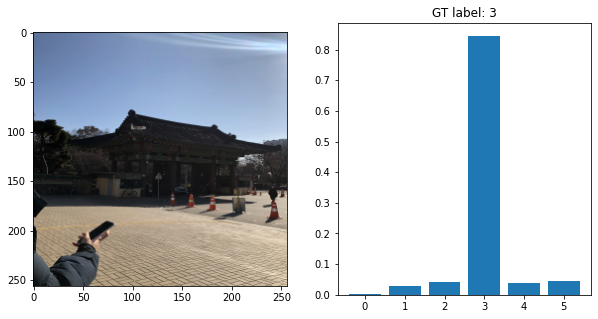

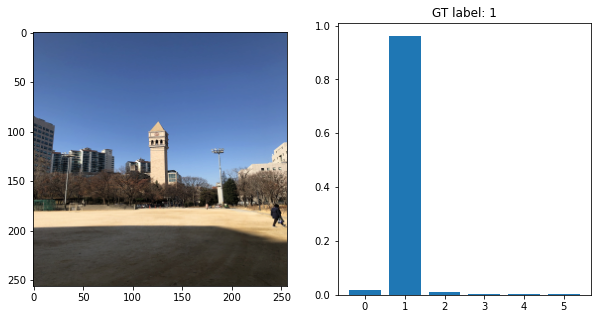

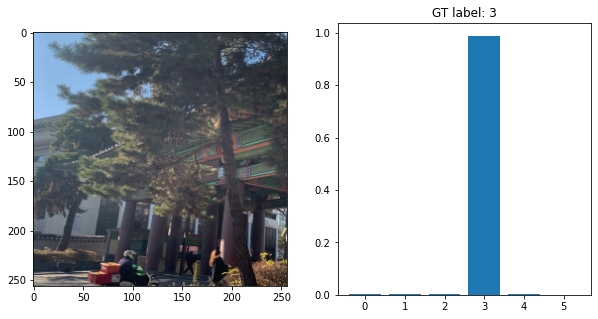

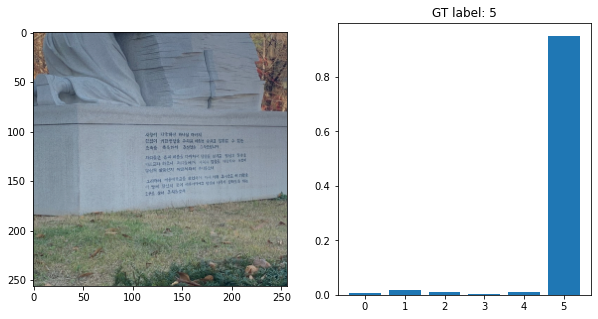

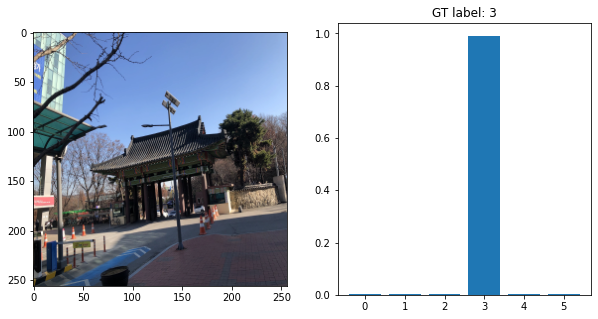

In [ ]:
for iter, image_label_dict in enumerate(data_loader_test):
  means_data = [124.50310906, 125.51703172, 118.66876903]
  stds_data = [70.97251122, 70.38826306, 78.19967981]
  model.eval().to(device) # 모델을 GPU로 보내줌 평가모드에서는 .eval을 꼭 해줘야 함
  image = image_label_dict['image'].to(device) # 이미지 GPU로 보내기  
  label = image_label_dict['label'].to(device) # 라벨 GPU로 보내기
  pred = model(image)
  pred = nn.Softmax(dim=1)(pred)
  pred = pred.detach().cpu().numpy()
  pred = pred.reshape(-1)
  image = image.detach().cpu().numpy()
  image = image.transpose(2,3,1,0)
  image = image.reshape(256,256,3)
  label = label.detach().cpu().numpy()
  image = image.astype(np.float)
  # image = image*255 # 이미지 플롯을 위한 normalize 해제
  image = image*stds_data + means_data
  plot_bar(pred, image ,label)
  if iter == 4:
    break

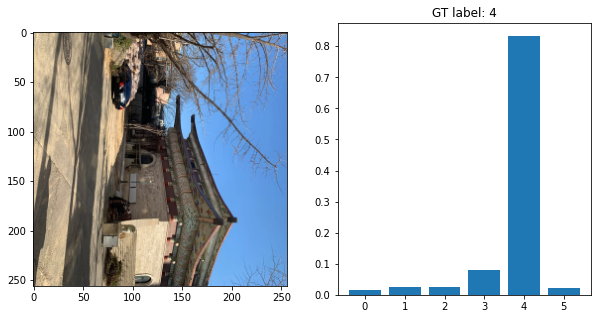

In [ ]:
# # 회전이미지 테스트 셀
# means_data = [124.50310906, 125.51703172, 118.66876903]
# stds_data = [70.97251122, 70.38826306, 78.19967981]
# model.eval().to(device) # 모델을 GPU로 보내줌 평가모드에서는 .eval을 꼭 해줘야 함
# image = cv.imread('/content/KakaoTalk_20201204_125744622_06.jpg')
# image = image.astype('uint8') # cvtColor할때 unit8 type이여야 에러가 안나서 추가함
# image = cv.cvtColor(image, cv.COLOR_BGR2RGB) # BGR 이미지를 RGB로 바꾸어줌 (OPEN CV 라이블러리는 default가 BGR이기 때문)
# image = cv.resize(image, (256,256), interpolation = cv.INTER_AREA) # 이미지의 사이즈를 변경
# image = (image-means_data)/stds_data
# image = np.expand_dims(image,axis=0)
# image = image.transpose(0,3,1,2)
# image = torch.FloatTensor(image)
# image = image.to(device) # 이미지 GPU로 보내기  
# label = image_label_dict['label'].to(device) # 라벨 GPU로 보내기
# # import pdb; pdb.set_trace()
# pred = model(image)
# pred = nn.Softmax(dim=1)(pred)
# pred = pred.detach().cpu().numpy()
# pred = pred.reshape(-1)
# image = image.detach().cpu().numpy()
# image = image.transpose(2,3,1,0)
# image = image.reshape(256,256,3)
# label = label.detach().cpu().numpy()
# image = image.astype(np.float)
# # image = image*255 # 이미지 플롯을 위한 normalize 해제
# image = image*stds_data + means_data
# plot_bar(pred, image ,[4])

## 앙상블

#### 앙상블1 concatenate 기반

In [ ]:
# del data_loader_train
# del datasets_train
# del data_loader_val
# del datasets_val
# del model

In [ ]:
# class MyEnsemble(nn.Module):
#     def __init__(self, modelA, modelB, nb_classes=6):
#         super(MyEnsemble, self).__init__()
#         self.modelA = modelA
#         self.modelB = modelB
#         # Remove last linear layer
#         self.modelA.neck = model.neck = nn.Sequential(
#             nn.Linear(out_features, embedding_size, bias=True),
#             nn.BatchNorm1d(embedding_size),
#             torch.nn.PReLU(),
#             nn.Identity()
#         )
#         self.modelB.neck = model.neck = nn.Sequential(
#             nn.Linear(out_features, embedding_size, bias=True),
#             nn.BatchNorm1d(embedding_size),
#             torch.nn.PReLU(),
#             nn.Identity()
#         )
#         # Create new classifier
#         self.classifier = nn.Linear(2048+512, nb_classes)
        
#     def forward(self, x):
#         import pdb;pdb.set_trace()
#         x1 = self.modelA(x.clone())  # clone to make sure x is not changed by inplace methods
#         x1 = x1.view(x1.size(0), -1)
#         x2 = self.modelB(x)
#         x2 = x2.view(x2.size(0), -1)
#         x = torch.cat((x1, x2), dim=1)
#         x = self.classifier(F.relu(x))
#         return x

# # Train your separate models
# # ...
# # We use pretrained torchvision models here
# model = Net(out_features = out_features, embedding_size = embedding_size, 
#             n_classes = n_classes, p_trainable = True, 
#             name = 'gluon_resnext101_64x4d', pretrained_weights = None)
# model.load_state_dict(torch.load('/content/drive/MyDrive/Mechanical_termproject/checkpoint/gluon_resnext101_64x4d/experiment1'))
# #import pdb; pdb.set_trace()
# model2 = Net(out_features = out_features, embedding_size = embedding_size, 
#             n_classes = n_classes, p_trainable = True, 
#             name = 'gluon_seresnext101_64x4d', pretrained_weights = None)
# model2.load_state_dict(torch.load('/content/drive/MyDrive/Mechanical_termproject/checkpoint/gluon_seresnext101_64x4d/experiment5'))

# # Freeze these models
# for param in model.parameters():
#     param.requires_grad_(False)

# for param in model2.parameters():
#     param.requires_grad_(False)

# # Create ensemble model
# model = MyEnsemble(model, model2)


# # names_pram=[]
# # for name_pram, _ in model.named_parameters():
# #     names_pram.append(name_pram)
# # for name_pram, param in model.named_parameters():
# #     param.requires_grad = False
# #     if name_pram in names_pram[-9:]:
# #         param.requires_grad = True

In [ ]:
# x = torch.randn(1 , 3, 256, 256)
# output = model(x)

In [ ]:
# model.modelA.neck = nn.Sequential(
#             nn.Linear(self.out_features, self.embedding_size, bias=True),
#             nn.BatchNorm1d(self.embedding_size),
#             torch.nn.PReLU()
#         )

In [ ]:
# ['AI', 'Clock tower', 'Front door Child', 'Stone statue', 'Front door Sejong', 'Museum']

### 앙상블2 voting방식

In [ ]:
# def ensemble_submission(modelA, modelB, data_loader_test):
#     # os.makedirs(datapath +'/checkpoint/' +name_A, exist_ok=True) # save파일을 저장할 디렉토리 생성(이미 있을시 스킵)
#     model_dir_A = datapath + '/checkpoint/'+ name_A + '/' + exp_A
#     modelA.load_state_dict(torch.load(model_dir_A))
#     modelA.eval().to(device) # 모델을 GPU로 보내줌 평가모드에서는 .eval을 꼭 해줘야 함

#     model_dir_B = datapath + '/checkpoint/'+ name_B + '/' + exp_B
#     modelB.load_state_dict(torch.load(model_dir_B))
#     modelB.eval().to(device) # 모델을 GPU로 보내줌 평가모드에서는 .eval을 꼭 해줘야 함
    
#     submission = pd.read_csv(os.path.join(datapath,'submission.csv'))
#     # submission= pd.read_csv(os.path.join(datapath,'submission.csv'))

#     for iter, image_label_dict in enumerate(tqdm(data_loader_test, desc='Creating submission file...')):
#         image = image_label_dict['image'].to(device) # 이미지 GPU로 보내기  
#         label = image_label_dict['label'].to(device) # 라벨 GPU로 보내기

#         pred_A = modelA(image)
#         pred_A = nn.Softmax(dim=1)(pred_A)
#         pred_A = pred_A.detach().cpu().numpy()
#         pred_B = modelB(image)
#         pred_B = nn.Softmax(dim=1)(pred_B)
#         pred_B = pred_B.detach().cpu().numpy()
#         pred_sum = pred_A + pred_B

#         submission['prediction'][iter] = np.argmax(pred_sum, 1)
#         submission['GT label'][iter] = label
#         # print('...Creating submission file {0:.>20.1f}% {1:0>5d}/37964'.format(((iter/len(data_loader_val))*100), iter))
#     os.makedirs(datapath + '/save_result/'+'/Ensemble/'+name_A, exist_ok=True)
#     submission.to_csv(datapath + '/save_result/'+'/Ensemble/'+ name_A+ '/' +'{}_{}.csv'.format(exp_A,exp_B), index=False)

#     print("Completed")

# # /content/drive/MyDrive/Mechanical_termproject/checkpoint/gluon_resnext101_64x4d_experiment1/gluon_resnext101_64x4d_epoch_010.pthresult_csv/gluon_resnext101_64x4d
# # prediction = model(X_test)
# # correct_prediction = torch.argmax(prediction, 1) == Y_test
# # accuracy = correct_prediction.float().mean()
# # print('Accuracy:', accuracy.item())

In [ ]:
# ## 앙상블할 모델 불러오기
# # 모델경로지정, save_name 지정
# modelA = Net(out_features = out_features, embedding_size = embedding_size, 
#           n_classes = n_classes, p_trainable = True, 
#           name = 'gluon_resnet152_v1s', pretrained_weights = None)
# # modelA = freeze_param(modelA)
# modelA.load_state_dict(torch.load('/content/drive/MyDrive/Mechanical_termproject/checkpoint/gluon_resnet152_v1s/experiment8'))
# #import pdb; pdb.set_trace()
# modelB = Net(out_features = out_features, embedding_size = embedding_size, 
#           n_classes = n_classes, p_trainable = True, 
#           name = 'gluon_seresnext101_64x4d', pretrained_weights = None)
# # modelB = freeze_param(modelB)
# modelB.load_state_dict(torch.load('/content/drive/MyDrive/Mechanical_termproject/checkpoint/gluon_seresnext101_64x4d/experiment5'))
# exp_A = 'experiment8'
# name_A = 'gluon_resnet152_v1s'
# exp_B = 'experiment5'
# name_B = 'gluon_seresnext101_64x4d'
# if mode == 'test':
#   with torch.no_grad():
#     ensemble_submission( modelA, modelB, data_loader_test)

In [ ]:
# # Accuracy
# submission = pd.read_csv('/content/drive/MyDrive/Mechanical_termproject/save_result/Ensemble/gluon_resnet152_v1s/experiment8_experiment5.csv')
# accuracy_test = (submission['prediction'] == submission['GT label']).sum()*100/len(submission)
# print("전체 Accuracy : {0:.2f}%" .format(accuracy_test))
# # create_tag('Test Accuracy {}%'.format(accuracy_test))

In [ ]:
# neptune.stop()

### 앙상블3 voting식 (모델3개)

In [ ]:
# def ensemble2_submission(modelA, modelB, modelC, data_loader_test):
#     model_dir_A = datapath + '/checkpoint/'+ name_A + '/' + exp_A
#     modelA.load_state_dict(torch.load(model_dir_A))
#     modelA.eval().to(device) # 모델을 GPU로 보내줌 평가모드에서는 .eval을 꼭 해줘야 함

#     model_dir_B = datapath + '/checkpoint/'+ name_B + '/' + exp_B
#     modelB.load_state_dict(torch.load(model_dir_B))
#     modelB.eval().to(device) # 모델을 GPU로 보내줌 평가모드에서는 .eval을 꼭 해줘야 함

#     model_dir_C = datapath + '/checkpoint/'+ name_C + '/' + exp_C
#     modelC.load_state_dict(torch.load(model_dir_C))
#     modelC.eval().to(device) # 모델을 GPU로 보내줌 평가모드에서는 .eval을 꼭 해줘야 함 
#     submission = pd.read_csv(os.path.join(datapath,'submission.csv'))
#     # import pdb; pdb.set_trace()
#     for iter, image_label_dict in enumerate(tqdm(data_loader_test, desc='Creating submission file...')):
#         image = image_label_dict['image'].to(device) # 이미지 GPU로 보내기  
#         label = image_label_dict['label'].to(device) # 라벨 GPU로 보내기
#         pred_A = modelA(image)
#         pred_A = nn.Softmax(dim=1)(pred_A)
#         pred_A = pred_A.detach().cpu().numpy()
#         pred_B = modelB(image)
#         pred_B = nn.Softmax(dim=1)(pred_B)
#         pred_B = pred_B.detach().cpu().numpy()
#         pred_C = modelC(image)
#         pred_C = nn.Softmax(dim=1)(pred_C)
#         pred_C = pred_C.detach().cpu().numpy()
#         pred_sum = pred_A + pred_B + pred_C

#         submission['prediction'][iter] = np.argmax(pred_sum, 1)
#         submission['GT label'][iter] = label
#     os.makedirs(datapath + '/save_result/'+'/Ensemble/'+name_A, exist_ok=True)
  
#     submission.to_csv(datapath + '/save_result/'+'/Ensemble/'+ name_A+ '/' +'{}_{}_{}.csv'.format(exp_A,exp_B,exp_C), index=False)
#     print("Completed")

In [ ]:
# ## 앙상블할 모델 불러오기
# # 모델경로지정, save_name 지정
# modelA = Net(out_features = 2048, embedding_size = embedding_size, 
#           n_classes = n_classes, p_trainable = True, 
#           name = 'gluon_resnet152_v1s', pretrained_weights = None)
# modelA.load_state_dict(torch.load('/content/drive/MyDrive/Mechanical_termproject/checkpoint/gluon_resnet152_v1s/experiment8'))
# exp_A = 'experiment8'
# name_A = 'gluon_resnet152_v1s'

# modelB = Net(out_features = 2048, embedding_size = embedding_size, 
#           n_classes = n_classes, p_trainable = True, 
#           name = 'gluon_seresnext101_64x4d', pretrained_weights = None)
# modelB.load_state_dict(torch.load('/content/drive/MyDrive/Mechanical_termproject/checkpoint/gluon_seresnext101_64x4d/experiment5'))
# exp_B = 'experiment5'
# name_B = 'gluon_seresnext101_64x4d'

# modelC = Net(out_features = 2048, embedding_size = embedding_size, 
#           n_classes = n_classes, p_trainable = True, 
#           name = 'gluon_resnet152_v1d', pretrained_weights = None)
# modelC.load_state_dict(torch.load('/content/drive/MyDrive/Mechanical_termproject/checkpoint/gluon_resnet152_v1d/experiment12'))
# exp_C = 'experiment12'
# name_C = 'gluon_resnet152_v1d'

In [ ]:
# with torch.no_grad():
#   ensemble2_submission( modelA, modelB, modelC , data_loader_test)


Completed


In [ ]:
# save_name = "experiment13" # 저장할 이름
# #실험조건을 넵튠에 업로드
# params = {'out_features':2048, 'embedding_size': embedding_size, 'n_classes' : n_classes, 'pretrained_weights':pretrained_weights,
#           'load_epoch':load_epoch, 'save_name':save_name, 'epochs':epochs, 'batch_size':batch_size, 'name':name,
#           'image width':img_w, 'image height':img_h, 'crop width':crop_w, 'crop height':crop_h}
# create_exp(name = 'hjkim_project', params = params, upload_source_files = upload_source_files)
# create_tag(save_name)

https://ui.neptune.ai/hjkim/sandbox/e/SAN-48


In [ ]:
# # Accuracy
# submission = pd.read_csv('/content/drive/MyDrive/Mechanical_termproject/save_result/Ensemble/gluon_resnet152_v1s/experiment8_experiment5_experiment12.csv')
# accuracy_test = (submission['prediction'] == submission['GT label']).sum()*100/len(submission)
# print("전체 Accuracy : {0:.2f}%" .format(accuracy_test))
# create_tag('Test Accuracy {}%'.format(accuracy_test))

전체 Accuracy : 93.48%


In [ ]:
# neptune.stop()

### 데이터 csv파일로 저장

In [ ]:
# ## 해당 함수는 데이터로더로부터 데이터를 추출하여 image 데이터와 그에 해당하는 라벨데이터를 리턴함
# def getdata_dataloader(data_loader):
#   images = []
#   labels = []
#   for iter, image_label_dict in enumerate(tqdm(data_loader)):
#     image = image_label_dict['image'].tolist()
#     label = image_label_dict['label'].tolist()
#     images.append(image)
#     labels.append(label)
#   images = np.array(images)
#   images = images.reshape(len(images),-1)
#   return images , labels

In [ ]:
# ## 해당함수는 위에서 정의한 getdata_dataloader함수를 사용하여 데이터로더로부터 데이터를 받아오고 csv파일로 가공하여 저장
# def csv_save(data_loader_train, mode):
#   os.makedirs(datapath +'/data_csv', exist_ok=True) # csv파일을 저장할 폴더 생성
#   images_data , labels_data   = getdata_dataloader(data_loader_train) # 위에서 정의한 함수로사용하여 데이터로더로부터 데이터받아오기
#   images_data = np.array(images_data)
#   images_data = images_data.reshape(len(images_data),-1)
#   images_data = pd.DataFrame(images_data)
#   images_data.to_csv(os.path.join(datapath, 'data_csv/{}.csv'.format(mode)), header=True, index=False)
#   # 라벨도 같은방식으로 저장
#   labels_data = np.array(labels_data)
#   labels_data = labels_data.reshape(len(labels_data),-1)
#   labels_data = pd.DataFrame(labels_data)
#   labels_data.to_csv(os.path.join(datapath, 'data_csv/{}_label.csv'.format(mode)), header=True, index=False)

In [ ]:
# ## 위에서 정의한 csv_save를 이용하여 train, validation, test 데이터를 각각 csv파일로 저장
# csv_save(data_loader_train, mode='train')
# csv_save(data_loader_val, mode='val')
# csv_save(data_loader_test, mode='test')

### Standardization을 위한 std값, mean값 구하기

In [ ]:
# tempval =  pd.read_csv('/content/drive/MyDrive/Mechanical_termproject/data_csv/val.csv') # 위에서 저장한 csv파일 경로
# temp = pd.read_csv('/content/drive/MyDrive/Mechanical_termproject/data_csv/train.csv') # 위에서 저장한 csv파일 경로
# temp = np.vstack((temp, tempval))
# temp = np.array(temp).reshape(-1,3,256,256)
# means = temp.mean(axis=(0,2,3))
# stds = temp.std(axis=(0,2,3))
# print(means)
# print(stds)
## 결과값
# [124.50310906 125.51703172 118.66876903]
# [70.97251122 70.38826306 78.19967981]

## 안쓰는 셀들 (백업본)

### 데이터로더 백업

In [ ]:
## 백업본
# # 데이터 로더 선언
# ## 데이터 로더는 크게 __init__, __len__, __getitem__ 3개의 함수로 되어있음.
# ## init함수는 class를 생성하자마자 호출되어짐 (이때 모든 이미지를 불러옴)
# class Custom_dataloader(Dataset):
#     def __init__(self, mode , datapath, transform):
#       self.datapath = datapath # 기본폴더경로
#       self.transform = transform # data augmentation 입력값
#       self.mode = mode # 모드입력값 / 'train'/ test
#       self.label_path = os.path.join(datapath,'label.csv')
#       if mode=='train':
#         self.datapath_mode = os.path.join(datapath,'train') # 기본폴더/train 경로 저장
#       elif mode == 'val':
#         self.datapath_mode = os.path.join(datapath,'val') # 기본폴더/val 경로 저장
#       elif mode == 'test':
#         self.datapath_mode = os.path.join(datapath,'test') # 기본폴더/val 경로 저장
      
#       # train일때 전체 이미지 불러오기
#       self.images = [] # 전체 이미지를 저장할 리스트선언
#       self.labels = [] # 전체 라벨을 저장할 리스트선언

      
#       for label, name in enumerate(tqdm(sorted(os.listdir(self.datapath_mode)))): # 테스트데이터셋이 있는 경로상에있는 폴더이름을 iteration 돌음
#         for i, img_name in enumerate(os.listdir(os.path.join(self.datapath_mode, name))): # 불러온 폴더이름안의 있는 파일들의 이름을 iteration 돌음
#           # try - except 에러처리문 (이미지를 불러올 수 없을때 skip// gif등 스킵됨)
#           try:
#             img = cv.imread(os.path.join(self.datapath_mode, name)+'/'+img_name) # 각 폴더에 있는 파일들의 이름으로 경로를 합쳐줌
#           except:
#             pass
#           if img is None:
#             continue
#           img = img.astype('uint8') # cvtColor할때 unit8 type이여야 에러가 안나서 추가함
#           img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # BGR 이미지를 RGB로 바꾸어줌 (OPEN CV 라이블러리는 default가 BGR이기 때문)
#           img = cv.resize(img, (256,256), interpolation = cv.INTER_AREA) # 이미지의 사이즈를 변경
#           self.images.append(img) # 가져온 이미지는 images 리스트에 append
#           self.labels.append(label) # labels 리스트에 각 이미지의 label append
#       self.images = np.array(self.images) # numpy의 transpose 함수를 사용하기위한 numpy array형태 변환
#       self.images = self.images.transpose(0, 3 , 1, 2) # 이미지의 shape를 (N, W, H, C) -> (N, C, W, H) 로 변경
#       self.images = self.images.tolist() # 다시 type를 list로 변경
      
#     def full_load():

#     def csv_exist():


#     def __len__(self):
#       return len(self.images) # 불러온 이미지 전체의 length를 반환

#     def __getitem__(self, idx):
#       # index가 tensor형일 경우에는 list형으로 바꿔줌
#       if torch.is_tensor(idx): #index가 tensor형태일 경우 list로 바꿔주는 오류처리문
#           idx = idx.tolist()
#       img = self.images[idx]
#       if self.transform is not None:
#         img = self.transform[img]
#       img = np.array(img).astype(np.float32)
      
#       img = torch.FloatTensor(img)

#       label = self.labels[idx]
#       label = np.array(label).astype(np.float32)
#       label = torch.LongTensor(label)
      
#       # image_tensor = torch.FloatTensor(self.images[idx])
#       # label_tensor = torch.FloatTensor(self.labels[idx])
#       data = {'image':img, 'label':label} # 이미지와 라벨을 딕셔너리 형태로 저장
#       return data # 위에서 저장한 data return 해줌

In [ ]:
# # 데이터 로더 선언 (기본틀... 차후수정)
# class FaceLandmarksDataset(Dataset):
#     def __init__(self, mode , datapath, transform):
#         self.datapath = datapath
#         self.transform = transform
#         self.mode = mode
#         self.label_path = os.path.join(datapath,'label.csv')
#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         # index가 tensor형일 경우에는 list형으로 바꿔줌
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

#         # train일때와 test일때 디렉토리값 변경
#         if self.mode == 'train':
#           datapath_train = os.path.join(datapath,'train')
#           images = []
#           for label, name in enumerate(os.listdir(datapath_train)):
#             for i, img_name in enumerate(os.listdir(os.path.join(datapath_train, name))):
#               print(os.path.join(datapath_train, name)+'/'+img_name)
          




#         elif self.mode == 'test':
#           datapath_test = os.path.join(datapath,'test')
        




          
        # image = self.images.iloc[idx,1:]
        # label = self.images.iloc[idx, 0]
        # image = np.array(image)
        # image = image.astype('float').reshape(28, 28, 1)
        # sample = self.transform(image=image)
        # sample = {'image': image, 'label': label}
        # return sample

In [ ]:
# def collate_fn(batch) :
#     image = [x['image'] for x in batch]
#     label = [x['label'] for x in batch]
#     return torch.tensor(image).float().cuda(), torch.tensor(label).long().cuda()

# def collate_fn_test(batch) :
#     image = [x['image'] for x in batch]
#     label = [x['label'] for x in batch]
#     return torch.tensor(image).float().cuda(), label

### 학습관련 백업코드

In [ ]:
# # Validation test
# model.eval().to(device) # 모델을 GPU로 보내줌 평가모드에서는 .eval을 꼭 해줘야 함
# for iter, image_label_dict in enumerate(data_loader_val):
#     image = image_label_dict['image'].to(device) # 이미지 GPU로 보내기  
#     label = image_label_dict['label'].to(device) # 라벨 GPU로 보내기
#     pred = model(image)
#     pred = nn.Softmax(dim=1)(pred)
#     pred = pred.detach().cpu().numpy()
#     submission['prediction'][iter] = np.argmax(pred, 1)
#     submission['GT label'][iter] = label
# print("Validation Accuracy : {0:.2f}%",end="" .format((submission['prediction'] == submission['GT label']).sum()*100/len(submission)))

In [ ]:
# for iter, image_label_dict in enumerate(data_loader_val):
#   submission = pd.read_csv(os.path.join(datapath,'label.csv'))
#   pred = model(image)
#   pred = nn.Softmax(dim=1)(pred)
#   pred = pred.detach().cpu().numpy()
#   submission['prediction'][iter] = np.argmax(pred, 1)
#   submission['GT label'][iter] = label
# print("Training Accuracy : {0:.2f}%" .format((submission['prediction'] == submission['GT label']).sum()*100/len(submission)))

### 파이토치 Data augmentation

In [ ]:
# transform = torchvision.transforms.Compose([
#     # torchvision.transforms.Resize((256,256)),                    #이미지의 크기
#     torchvision.transforms.ColorJitter(hue=.05, saturation=.05), #사진의 밝기를 변화시키는 코드
#     torchvision.transforms.RandomHorizontalFlip(),               #죄우 대칭을 위한 코드
#     torchvision.transforms.ToTensor()
# ])